# LSTM Stock Predictor Using Closing Prices

## Data Preparation

In [1]:
import numpy as np
import pandas as pd
#import hvplot.pandas

In [2]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load Tickers Data
df = pd.read_csv('../Data/Cleandata/Rawdata/nflx_data.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

df.head()

,Closing Price,Volume
Date,,
2019-01-08 16:00:00,320.27,15359180
2019-01-09 16:00:00,319.96,13343152
2019-01-10 16:00:00,324.66,13472475
2019-01-11 16:00:00,337.59,19500429
2019-01-14 16:00:00,332.94,10499582


In [4]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [5]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

In [6]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[: split]

y_train = y[: split]
y_test = y[: split]

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# YOUR CODE HERE!
scaler = MinMaxScaler()

scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)

y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [8]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.21751225]
  [0.21648563]
  [0.2320506 ]
  [0.27487084]
  [0.25947145]]

 [[0.21648563]
  [0.2320506 ]
  [0.27487084]
  [0.25947145]
  [0.33133528]]

 [[0.2320506 ]
  [0.27487084]
  [0.25947145]
  [0.33133528]
  [0.32057226]]

 [[0.27487084]
  [0.25947145]
  [0.33133528]
  [0.32057226]
  [0.32653332]]

 [[0.25947145]
  [0.33133528]
  [0.32057226]
  [0.32653332]
  [0.27987151]]] 

X_test sample values:
[[[0.21751225]
  [0.21648563]
  [0.2320506 ]
  [0.27487084]
  [0.25947145]]

 [[0.21648563]
  [0.2320506 ]
  [0.27487084]
  [0.25947145]
  [0.33133528]]

 [[0.2320506 ]
  [0.27487084]
  [0.25947145]
  [0.33133528]
  [0.32057226]]

 [[0.27487084]
  [0.25947145]
  [0.33133528]
  [0.32057226]
  [0.32653332]]

 [[0.25947145]
  [0.33133528]
  [0.32057226]
  [0.32653332]
  [0.27987151]]]


---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 30
dropout_fraction = 0.2

#layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1)
))
model.add(Dropout(dropout_fraction))

#layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

#layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

model.add(Dense(1))

In [11]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 5, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 30)             7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 30)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [13]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=30, shuffle=False, batch_size=90, verbose=1)

Epoch 1/30
4/4 [==============================] - 0s 6ms/step - loss: 0.0998
Epoch 2/30
4/4 [==============================] - 0s 6ms/step - loss: 0.0773
Epoch 3/30
4/4 [==============================] - 0s 6ms/step - loss: 0.0553
Epoch 4/30
4/4 [==============================] - 0s 6ms/step - loss: 0.0341
Epoch 5/30
4/4 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 6/30
4/4 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 7/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0174
Epoch 8/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0190
Epoch 9/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 10/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 11/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0134
Epoch 12/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 13/30
4/4 [==============================] - 0s 5ms/step - loss: 0.

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [14]:
# Evaluate the model
model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.0024


0.0024362606927752495

In [15]:
# Make some predictions
predicted = model.predict(X_test)

In [16]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel(),
}, index = df.index[-len(real_prices): ]) 
stocks.tail()

,Real,Predicted
Date,,
2020-12-31 16:00:00,413.44,442.765564
2021-01-04 16:00:00,419.73,430.525665
2021-01-05 16:00:00,425.92,423.120453
2021-01-06 16:00:00,427.31,418.098846
2021-01-07 16:00:00,421.97,420.463013


<AxesSubplot:xlabel='Date'>

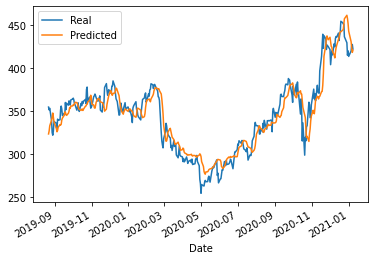

In [18]:
# Plot the real vs predicted values as a line chart
stocks.plot()

In [20]:
for i in stocks:
    if stocks["Predicted"][i] > stocks["Predicted"][i - 1]:
        stocks["Signal"][i] += .5
    if stocks["Real"][i] > stocks["Real"][i - 1]:
        stocks["Signal"][i].append() += .5

SyntaxError: cannot assign to function call (<ipython-input-20-de037d9c7fe5>, line 5)